In [168]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
file_path = '../results/2025-04-07/23/000068513-A6_VdP1mode_Wigner_AWG_Cam.h5'

# Open the .h5 file in read mode
with h5py.File(file_path, 'r') as file:
    # Print the names of the groups/datasets in the file
    print("Keys in the file:", list(file.keys()))
    
    # Assuming there's a dataset named 'data' in the file
    # Modify this part according to your file's structure
    data = file['datasets']
    print(file['datasets'].keys())

    print(file['archive'].keys())
    #print(file['archive']['__param__SDF'].keys())

    print(file['expid'][()])


    rabi_t= data['beta_index'][:]
    pmt_count=data['pmt_counts_avg_thresholded'][:]

plt.figure()
plt.plot(rabi_t, pmt_count)
plt.scatter(rabi_t, pmt_count,c='red',s=20)
plt.xlabel('${\\rm t}(\mu s)$')
plt.ylabel('<z>')


num_beta_r=21
num_beta_theta=20
pmt_count=pmt_count.reshape(num_beta_r,num_beta_theta)




In [170]:
eta1=0.134#0.134
#0.0944#0.0944
eta2=0.134#0.134#0.134
#0.0717
Rabi_readout1=0.070*2*np.pi
Rabi_readout2=0.070*2*np.pi
beta_time_range_us1 = 30
beta_time_range_us2 = 30
beta_range1=eta1*Rabi_readout1*beta_time_range_us1
beta_range2=eta2*Rabi_readout2*beta_time_range_us2
beta_range=beta_range1
print(beta_range1, beta_range2)

1.768088345440336 1.768088345440336


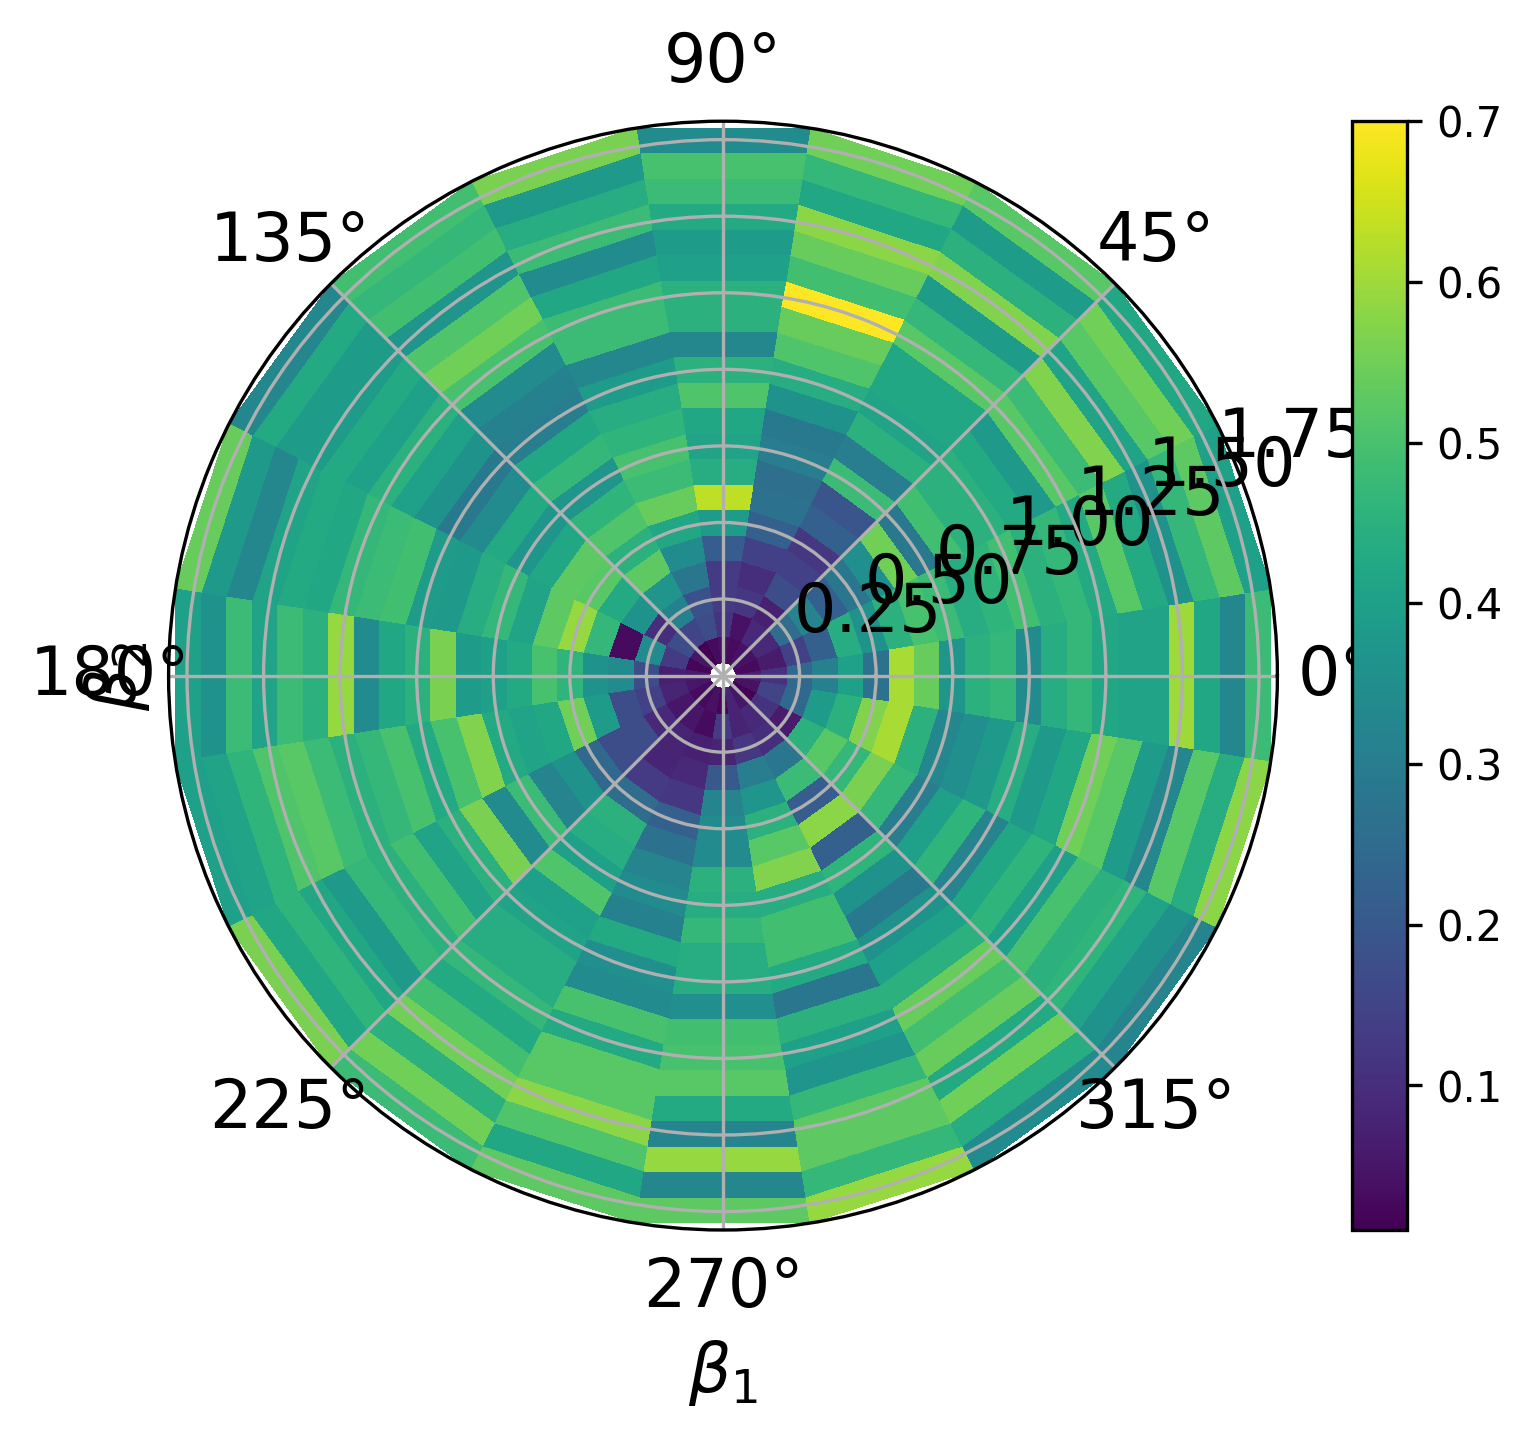

In [171]:
import matplotlib.colors as mcolors
cmap = plt.cm.viridis  # You can choose any colormap
cmap = cmap.copy()     # Copy the colormap to modify it
cmap.set_bad(color='gray')  # Set NaN values to gray


# Create beta values
R = np.zeros((num_beta_r, num_beta_theta))
Theta = np.zeros((num_beta_r, num_beta_theta))
for i in range(num_beta_r):
    #pmt_count[i]=np.mean(pmt_count[i])
    for j in range(num_beta_theta):
        R[i][j] = (beta_range1*(i+1.0)/num_beta_r)
        Theta[i][j] = (2*np.pi*j/num_beta_theta)

plt.figure(dpi=300)
ax = plt.subplot(111, projection='polar')
c = ax.pcolormesh(Theta, R, pmt_count, cmap=cmap)

plt.xlabel('$\\beta_1$',fontsize=16)
plt.ylabel('$\\beta_2$',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.colorbar(c)

In [182]:
def plot_fft_polar(pmt_count, N_r, N_theta):
    # Create beta values
    R = np.zeros((num_beta_r, num_beta_theta))
    Theta = np.zeros((num_beta_r, num_beta_theta))
    for i in range(num_beta_r):
        for j in range(num_beta_theta):
            R[i][j] = (beta_range*(i+1.0)/num_beta_r)
            Theta[i][j] = (2*np.pi*j/num_beta_theta)
    
    # Perform 2D FFT
    fft_data = np.zeros((N_r, N_theta), dtype=complex)

    sigma_r = num_beta_r*0.35

    for i in range(N_r):
        for j in range(N_theta):
            alpha_r = (i+1.0)/N_r/(beta_range/num_beta_r)
            alpha_theta = (2*np.pi*j/N_theta)
            fft_data[i][j] = 0
            for k in range(num_beta_r):
                for l in range(num_beta_theta):
                    factor1 = alpha_r*R[k][l]*np.cos(Theta[k][l])*np.cos(alpha_theta)
                    factor2 = alpha_r*R[k][l]*np.sin(Theta[k][l])*np.sin(alpha_theta)
                    fft_data[i][j] += pmt_count[k][l]*R[k][l]*np.exp(-1.0j*(factor1+factor2))*np.exp(-k**2/2/sigma_r**2)
    
    magnitude_spectrum = np.abs(fft_data)
    sum_magnitude_spectrum = 0.0
    #normalize the data
    for i in range(N_r):
        for j in range(N_theta):
            alpha_r = (i+1.0)/N_r/(beta_range/num_beta_r)
            sum_magnitude_spectrum += magnitude_spectrum[i][j]*alpha_r

    return magnitude_spectrum/sum_magnitude_spectrum


# Parameters
N_r = 40
N_theta = 50

print(np.mean(pmt_count[-num_beta_theta*8:]))
magnitude_spectrum = plot_fft_polar(pmt_count-np.mean(pmt_count[-num_beta_theta*8:]), N_r, N_theta)



0.3737142857142857


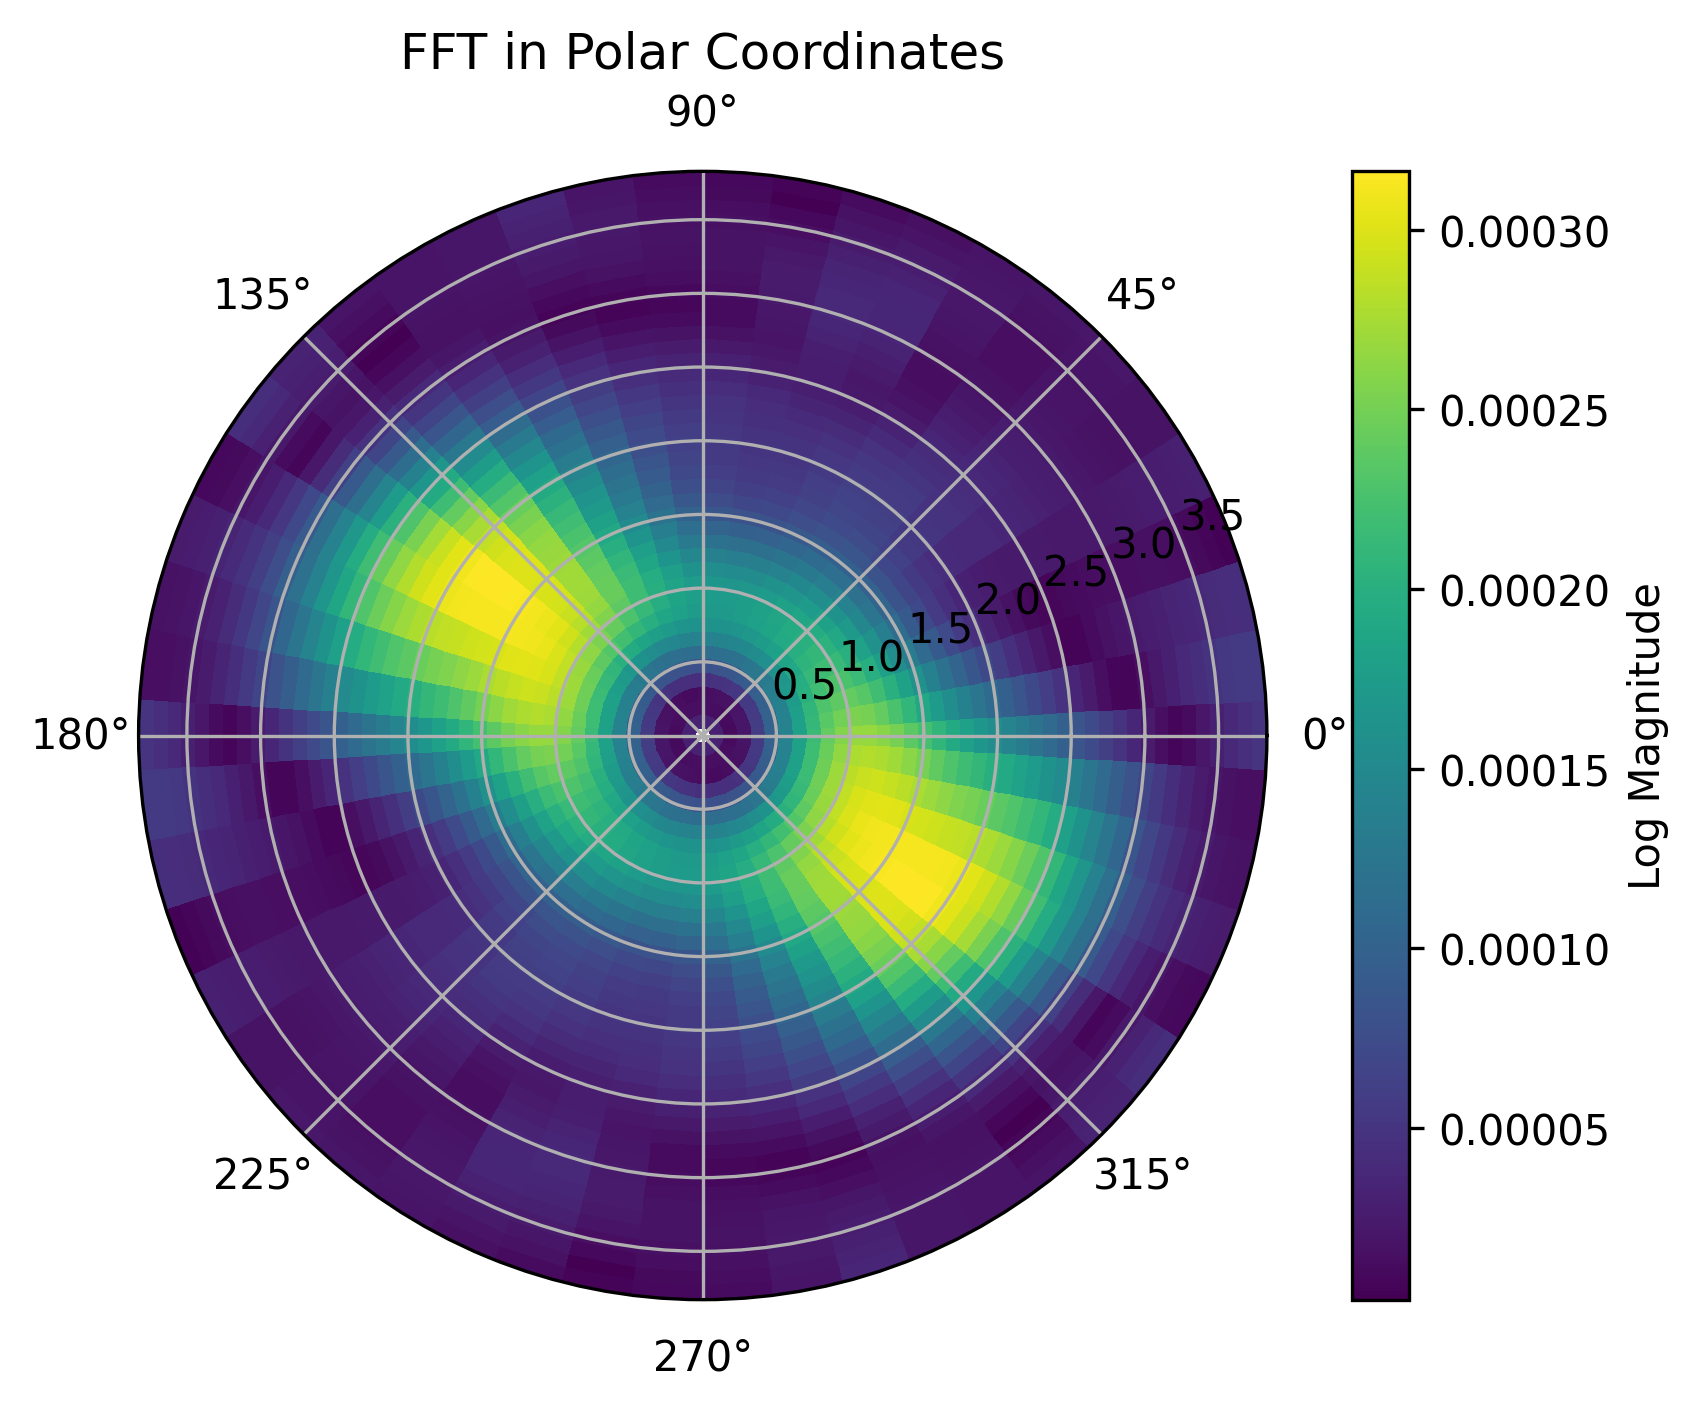

In [183]:
# Create frequency axes for polar FFT
k_r = [(i+1.0)/N_r/(beta_range/num_beta)/2/np.pi*2 for i in range(N_r)]
k_theta = [(2*np.pi*j/N_theta) for j in range(N_theta)]

# Plot FFT magnitude spectrum in polar coordinates
fig=plt.figure(dpi=300)
ax2 = fig.add_subplot(111, projection='polar')
c2 = ax2.pcolormesh(k_theta, k_r, np.abs(magnitude_spectrum), cmap='viridis')
plt.colorbar(c2, ax=ax2, label='Log Magnitude')
ax2.set_title('FFT in Polar Coordinates')

plt.tight_layout()
plt.show()